In [92]:
from scipy.stats.stats import pearsonr

In [223]:
CSV_IN = 'datos/Base datos_INTA_ascii_limpio.csv'
CLIMA_CSV_IN = 'datos/Base datos_INTA_ascii_limpio.csv'

df = pd.read_csv(CSV_IN, index_col='id', parse_dates=True)
print 'Cargado dataframe de tamaño %d filas x %d columnos de "%s"' % (df.shape[0], df.shape[1], CSV_IN)
clima = pd.read_csv('datos/clima_datos_unidos.csv', index_col='Date', parse_dates=True)
print 'Cargado dataframe de tamaño %d filas x %d columnos de "%s"' % (clima.shape[0], clima.shape[1], CLIMA_CSV_IN)

clima['TAVG'] = (clima['TMAX'] + clima['TMIN']) / 2.0
clima.head(3)

Cargado dataframe de tamaño 423 filas x 34 columnos de "datos/Base datos_INTA_ascii_limpio.csv"
Cargado dataframe de tamaño 2922 filas x 5 columnos de "datos/Base datos_INTA_ascii_limpio.csv"


,ESOL,RAIN,RHUM,TMAX,TMIN,TAVG
Date,,,,,,
2006-01-01,22.4,0,60,29.5,19,24.25
2006-01-02,24.3,0,76,37.2,21,29.10
2006-01-03,20.0,0,63,34.2,17,25.60


In [94]:
# Borrar filas con fechas invalidas
fecha_cols = []
for c in df.columns:
    if 'fecha' in c:
#         print c
        fecha_cols.append(c)
        df[c] = pd.to_datetime(df[c]).astype('datetime64[ns]')

# df[['fenologia_cosecha_fecha','fenologia_siembra_fecha']].head()
df['dias_siembra_cosecha'] = (df['fenologia_cosecha_fecha'] - df['fenologia_siembra_fecha']).apply(
    lambda dt: dt / np.timedelta64(24, 'h'))
antes = len(df)
df = df[df['dias_siembra_cosecha'] < 365]
df = df[pd.notnull(df['dias_siembra_cosecha'])]
print 'Borrando %d/%d filas invalidas, quedan %d' % (antes - len(df), antes, len(df))

Borrando 41/423 filas invalidas, quedan 382


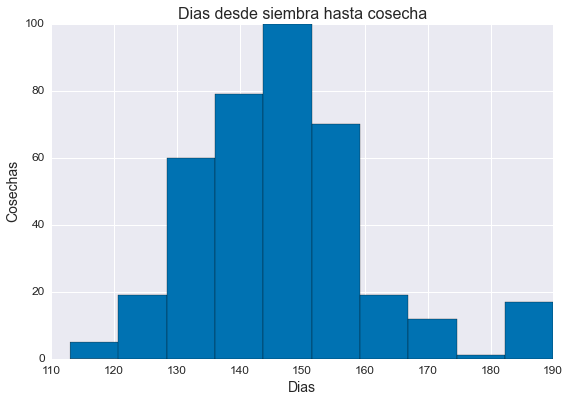

In [95]:
fig, ax = plt.subplots(1)
ax.hist(df['dias_siembra_cosecha'])
ax.set_title('Dias desde siembra hasta cosecha')
ax.set_xlabel('Dias')
ax.set_ylabel('Cosechas')

In [96]:
def computar_clima_critical_frac(tmin, tmax):
    clima_critical_frac = []
    for siembra, cosecha in zip(df['fenologia_siembra_fecha'], df['fenologia_cosecha_fecha']):
        dias_cultivos = clima[siembra:cosecha]
        criticales = ((dias_cultivos['TMAX'] <= tmax) & (dias_cultivos['TMIN'] >= tmin)).sum()
#         criticales = ((dias_cultivos['TAVG'] <= tmax) & (dias_cultivos['TAVG'] >= tmin)).sum()
        clima_critical_frac.append(criticales * 1.0 / len(dias_cultivos))
    df['clima_critical_frac'] = clima_critical_frac

In [221]:
TEMPS_20 = range(0, 41, 2)
TEMPS_40 = range(0, 41)
TEMPS = TEMPS_40
all_rows = []
for tmin in TEMPS:
    row = []
    for tmax in TEMPS:
        if tmax <= tmin:
            r, p = 0.0, 1.0
        else:
            computar_clima_buena_frac(tmin, tmax)
            r, p = pearsonr(df['clima_critical_frac'], df['rendimiento_seco_kg_ha'])
            if np.isnan(r):
                r, p = 0, 1
        row.append(r)
        print tmin, tmax, '%.4f %.4f' % (r, p)
    all_rows.append(row)

vals = []
for i in range(len(TEMPS)):
    for j in range(len(TEMPS)):
        vals.append([TEMPS[i], TEMPS[j], all_rows[i][j]])

vals.sort(key = lambda v: -abs(v[-1]))
for v in vals[:20]:
    print v

[18, 32, -0.51368669113302723]
[16, 36, -0.50485448876590389]
[18, 36, -0.44943467350562682]
[14, 36, -0.43668542561267121]
[16, 34, -0.42149242046292396]
[18, 34, -0.40509593070396294]
[24, 36, -0.40468474862825965]
[14, 24, 0.3917232138698567]
[16, 38, -0.39138190736418438]
[20, 36, -0.38579404633596337]
[18, 38, -0.37362918863955785]
[16, 32, -0.37325813522100437]
[6, 36, -0.36324833027796033]
[18, 40, -0.36220219800406978]
[22, 36, -0.35714118575242221]
[18, 30, -0.3483573389515513]
[16, 40, -0.34346863344220135]
[12, 36, -0.34307838527637996]
[2, 36, -0.34192966938405445]
[0, 36, -0.33217732570119191]


Saving to figuras/heatmap_temp_2c.png


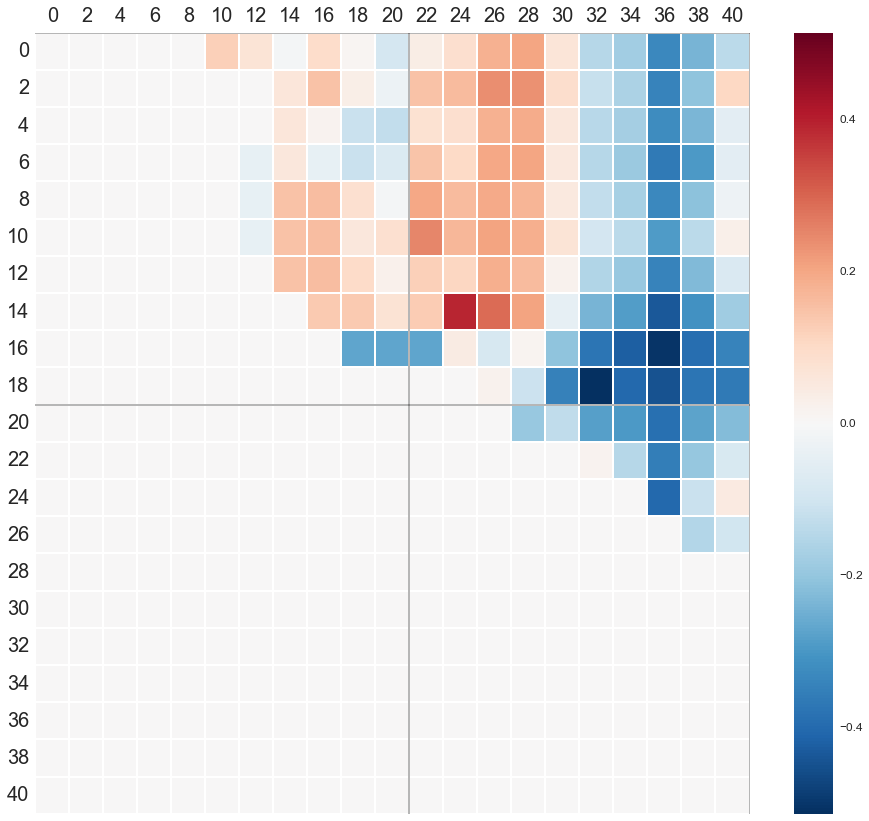

In [207]:
# all_rows_20 = all_rows
# all_rows_40 = all_rows
all_rows, TEMPS = all_rows_20, TEMPS_20
# all_rows, TEMPS = all_rows_40, TEMPS_40

temps_with_deg = [u'%d°' % t for t in TEMPS]
hotframe = pd.DataFrame(all_rows, index=TEMPS, columns=TEMPS)


fig, ax = plt.subplots(1)
fig.set_size_inches(16, 14)
sns.heatmap(hotframe, ax=ax)
fontsize = 13 if (TEMPS[1] == 1) else 20
for value in range(11,41,10):
    alpha = 0.33
    color = 'black'
    linestyle = '-'
    xy = [min(hotframe.index.values), 1 + max(hotframe.index.values)]
    ax.plot([value, value], xy, alpha=alpha, color=color, linestyle=linestyle)
    ax.plot(xy, [value, value], alpha=alpha, color=color, linestyle=linestyle)

if TEMPS[1] == 2:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(35)
ax.xaxis.tick_top()
ax.set_xticklabels([t.get_text() for t in ax.get_xticklabels()], rotation=0, fontsize=fontsize)
ax.set_yticklabels([t.get_text() for t in ax.get_yticklabels()], rotation=0, fontsize=fontsize)
filename = 'figuras/heatmap_temp_%dc.png' % TEMPS[1]
print 'Saving to', filename
fig.savefig(filename)
pass

In [154]:
def add_fit(df, a, b, ordenes=1, colors=None, fig=None):
    if not fig:
        fig = plt.gcf()
    if not isinstance(ordenes, list):
        ordenes = [ordenes]
    ax = fig.get_axes()[0]
    if not colors:
        colors = ['gray']
        if len(ordenes) > 0:
            colors = sns.color_palette()[1:]
        if len(ordenes) > colors:
            colors = sns.color_palette('hls', len(ordenes))
    for i,o in enumerate(ordenes):
        col = colors[i]
        coeffs = np.polyfit(df[a].values, df[b].values, o)
        f = np.poly1d(coeffs)
        pred = f(df[a].values)
        r, p = pearsonr(pred, df[b].values)
        x = np.linspace(min(df[a]), max(df[a]), 200)
        y = f(x)
        ax.plot(x, y, color=col, alpha=0.7, linestyle='--',
                 linewidth=2, label='Fit %do (R2 = %.4f, p = %.4f)' % (o, r, p))
    ax.legend(loc='upper right')

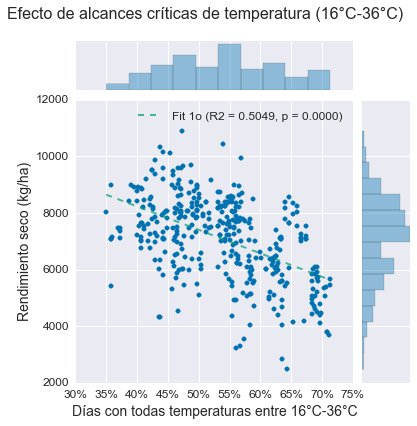

In [187]:
tmin, tmax = 16, 36
computar_clima_buena_frac(tmin, tmax)
sns.jointplot(df['clima_critical_frac'], df['rendimiento_seco_kg_ha'])
add_fit(df, 'clima_critical_frac','rendimiento_seco_kg_ha', 1)
fig = plt.gcf()
ax = fig.get_axes()[0]
fig.subplots_adjust(left=0.2, top=0.9)
ax.set_xticklabels(['%.0f%%' % (p*100) for p in ax.get_xticks()])
ax.set_xlabel(u'Días con todas temperaturas entre %d°C-%d°C' % (tmin, tmax))
ax.set_ylabel('Rendimiento seco (kg/ha)')
fig.suptitle(u'Efecto de alcances críticas de temperatura (%d°C-%d°C)' % (tmin, tmax), fontsize=16)
fig.savefig('figuras/joint_temp_%d_%d.png' % (tmin, tmax))